# Dinámica del Cluster Coma (Abell 1656)

En primer lugar, se procedió a cargar todas las librerías que se utilizarán en el programa:

In [99]:
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astropy.table import Table, vstack
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import seaborn as sns
import numpy as np
import pandas as pd

Luego, se cargó el archivo ¨Data Coma Cluster.csv¨ que contiene una tabla con los datos de las Coordenadas Ecuatoriales J2000 (RA y DEC ambas en grados °), las velocidades (km/s) y los valores de redshift del query realizado al catálogo del NED NASA/IPAC Extragalactic Database:

In [100]:
dataframe = pd.read_csv(r"C:\Users\amrd_\Downloads\Data Coma Cluster.csv")
print(dataframe)

                       Object Name         RA       DEC  Velocity  Redshift
0          2MASS J12591343+2758329  194.80575  27.97586       NaN       NaN
1                         NGC 4874  194.89878  27.95927    7167.0  0.023907
2         ABELL 1656:[EDG2007] 083  194.84417  27.91558       NaN       NaN
3      COMAi J130018.299+280240.53  195.07625  28.04459       NaN       NaN
4                      [ASD2005] 3  194.90800  27.97000       NaN       NaN
...                            ...        ...       ...       ...       ...
49994    WISEA J125948.39+280816.5  194.95157  28.13771       NaN       NaN
49995   SSTSL2 J130017.24+280551.6  195.07184  28.09767       NaN       NaN
49996    WISEA J130031.30+275933.4  195.13046  27.99263       NaN       NaN
49997   SSTSL2 J125956.42+280807.0  194.98511  28.13528       NaN       NaN
49998     ABELL 1656:[EF2011] 4352  195.05542  28.10938       NaN       NaN

[49999 rows x 5 columns]


In [101]:
# Copia del dataframe sin considerar la columna de Object Name
df=dataframe[['RA','DEC','Velocity','Redshift']]

Del paper consultado, sabemos que las galaxias correspondientes al Cúmulo de Coma tienen velocidades entre los 2 000 km/s y los 10 000 km/s, por lo que se procedió a filtrar el dataframe result de manera que solo trabajemos con las galaxias que cumplan con esa condición:

In [102]:
min_velocity_coma = 2000
max_velocity_coma = 10000

In [103]:
df = df.query('Velocity >= @min_velocity_coma and Velocity <= @max_velocity_coma')

Se extrajo los datos de la columna velocidades:

In [104]:
velocities = df['Velocity']
len(velocities)

264

Se realizó el recuento de las galaxias que poseen un mismo valor de velocidades:

In [105]:
velocities_value_counts = pd.DataFrame(velocities.value_counts())
velocities_value_counts = velocities_value_counts.reset_index()
velocities_value_counts.columns = ['Velocity', 'Number of Galaxies']
velocities_value_counts

,Velocity,Number of Galaxies
0,7195.0,4
1,6895.0,3
2,6805.0,3
3,7105.0,3
4,6955.0,3
...,...,...
239,6929.0,1
240,6094.0,1
241,7493.0,1
242,7135.0,1


En este caso, se accedió a la lista de catálogos del Data Release 16 (DR16) del Sloan Digital Sky Surveys (SDSS):

In [106]:
catalog_list_sdss = Vizier.find_catalogs('SDSS DR16')
for k, v in catalog_list_sdss.items():
    print(k, ': ', v.description)

V/154 :  Sloan Digital Sky Surveys (SDSS), Release 16 (DR16) (Ahumada+, 2020)
J/ApJ/912/91 :  A value-added catalog for SDSS DR16 quasars at z<0.7 (Toba+, 2021)
J/AJ/159/199 :  OCCAM. IV. Open cluster abundances using APOGEE DR16 (Donor+, 2020)
J/MNRAS/514/1231 :  SDSS DR16 compact galaxy groups (Zandivarez+, 2022)


Aquí se procedió a realizar un query al catálogo V/1554 en la región desde el centro del Cúmulo de Coma (Abell 1656) hasta su radio aproximado que es de 30 arcmin:

In [107]:
results_test_sdss = Vizier.query_region("A1656", radius="0d30m0s", catalog='V/154')
print(results_test_sdss)

TableList with 1 tables:
	'0:V/154/sdss16' with 28 column(s) and 50 row(s) 


In [108]:
# Nombres de las columnas de la tabla del catálogo
print(results_test_sdss[0].colnames)

['objID', 'RA_ICRS', 'DE_ICRS', 'mode', 'class', 'clean', 'e_RA_ICRS', 'e_DE_ICRS', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'e_umag', 'e_gmag', 'e_rmag', 'e_imag', 'e_zmag', 'zsp', 'e_zsp', 'f_zsp', 'zph', 'e_zph', '__zph_', 'Q', 'SDSS16', 'Sp-ID', '_tab1_130']


Se definió un filtro para acceder a las columnas que son de interés del query al SDSS DR16, que son los datos de las galaxias (¨class¨ = 3) que corresponden a las Coordenadas Ecuatoriales J2000 (¨RA_ICRS¨ y ¨DE_ICRS¨ ambas en grados °), los redshifts (zsp) y las magnitudes en diferentes filtros (u, g, r, i y z) junto con sus errores respectivos.

In [109]:
v1 = Vizier(columns=['RA_ICRS', 'DE_ICRS', 'zsp','umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag'],
            column_filters={'class': '==3', 'mode': '==1'})

Ahora se realizó el query definitivo al catálogo V/154 en la region de 30 arcmin de radio del centro del Cúmulo de Coma:

In [110]:
results_coma_sdss16 = v1.query_region('A1656', radius='0d30m0s', catalog='V/154')
print(results_coma_sdss16)

TableList with 1 tables:
	'0:V/154/sdss16' with 13 column(s) and 50 row(s) 


In [111]:
# El resultado fue una tabla con los datos respectivos correspondientes a 50 galaxias
sdss_dr16 = results_coma_sdss16[0]
len(sdss_dr16)

50

In [112]:
# Se convirtió la tabla de Astropy en un dataframe y se renombraron las columnas respectivas
sdss = pd.DataFrame(np.array(sdss_dr16))
sdss = sdss.rename(columns={ 'zsp': 'Redshift','DE_ICRS': 'DEC', 'RA_ICRS': 'RA'})

Luego, se procedió a concatenar los dataframes del archivo csv (data de velocidades obtenida del query al NED)

In [113]:
result_total = pd.concat([df, sdss])

In [114]:
result_total = result_total.drop_duplicates(subset=['RA'])
result_total = result_total.drop_duplicates(subset=['DEC'])
result_total

,RA,DEC,Velocity,Redshift,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag
1,194.898780,27.959270,7167.0,0.023907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,194.952460,27.982740,5358.0,0.017872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,194.979550,28.128360,7564.0,0.025231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,194.855530,27.967930,7706.0,0.025704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,195.004290,28.081860,7765.0,0.025900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,195.108335,27.516845,NaN,NaN,22.518999,0.299,22.134001,0.087,21.430000,0.069,21.518999,0.116,21.525999,0.485
46,195.117908,27.512141,NaN,NaN,24.316999,1.932,23.485001,0.548,21.009001,0.096,20.152000,0.072,21.735001,1.214
47,195.122902,27.511571,NaN,NaN,23.790001,0.711,22.358000,0.104,22.195999,0.124,23.039000,0.379,22.075001,0.641
48,195.114629,27.526350,NaN,NaN,23.056000,0.516,22.629999,0.149,21.617001,0.095,21.052999,0.092,22.033001,0.808


A continuación, se definió un algoritmo que pueda separar la data de las velocidades con sus recuentos respectivos para poder realizar el histograma de velocidades del Cúmulo de Coma:

In [115]:
# Se definió el número de bins a utilizar en el histograma de velocidades
bins = 20

# Valores máximo y mínimo de las velocidades
minimo = min(velocities)
maximo = max(velocities)

# Cálculo del ancho de cada bin
ancho = (maximo-minimo)/bins

# Función que retorna el número de galaxias cuyas velocidades están en el bin definido entre los valores de velocidades minimun y maximum
def histograma_intervalo(minimum,maximum):
	bin_velocities = velocities.loc[lambda x : (x >= minimum) & (x <= maximum)]
	return len(bin_velocities)

# Función que devuelve la data de los rangos de velocidades de cada bin y los recuentos respectivos de cada uno en un array
def histograma(velocities):
	x = []
	y = []

	for i in range(20):
		x.append(minimo+i*ancho+ancho/2)
		ret_aux = histograma_intervalo(minimo+i*ancho,minimo+(i+1)*ancho)
		y.append(ret_aux)
        
	x = np.array(x)
	y = np.array(y)
	return np.array([x,y])

In [116]:
# Se aplicó la función histograma a los datos de velocidades 
histogram_velocities = histograma(velocities)

Se procedió a realizar el gráfico del histograma de velocidades para el Cúmulo de Coma:

(2000.0, 10000.0)

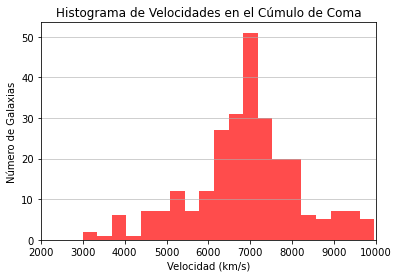

In [117]:
plt.ticklabel_format(style='plain')
plt.hist(velocities,bins=20, color='red', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title('Histograma de Velocidades en el Cúmulo de Coma')
plt.xlabel('Velocidad (km/s)')
plt.ylabel('Número de Galaxias')
plt.xlim(2000,10000)

Definición de la función Gauss (curva gausiana):

$$
y(x)=Ae^{-\frac{({x-x_0})^2}{2\sigma^2}}
$$

$$A= Amplitud \space(valor \space máximo)
$$

$$x_0= Media
$$

$$\sigma= Desviación\space Estándar
$$

In [118]:
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

Se utilizó la función curve_fit para en base a los datos del histograma, calcular los valores óptimos de los parámetros del Gaussian Fit:

In [119]:
parameters, covariance = curve_fit(gauss, histogram_velocities[0], histogram_velocities[1],p0=[51,7000,1000])

In [120]:
parameters

array([  38.99842214, 6986.64371744,  796.4792731 ])

In [121]:
# Valor óptimo de la desviación estándar
sigma = parameters[2]
sigma

796.4792731004667

In [122]:
tres_sigma = 3*sigma
tres_sigma

2389.4378193014

In [123]:
# Valor óptimo de la media
media = parameters[1]
media

6986.643717437546

Cálculo de los valores límites máximo y mínimo de las velocidades dentro del rango de 3 sigma de la media:

In [124]:
min_limit = media-tres_sigma
max_limit = media+tres_sigma
print([min_limit,max_limit])

[4597.205898136146, 9376.081536738946]


Se efectuó un scatter plot de las velocidades del Cúmulo de Coma y el fit gausiano:

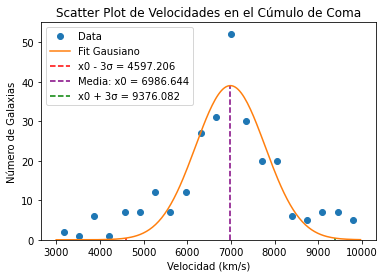

In [125]:
x = np.linspace(minimo,maximo,200)
y = gauss(x,*parameters)

plt.title('Scatter Plot de Velocidades en el Cúmulo de Coma')
plt.plot(histogram_velocities[0], histogram_velocities[1], 'o', label='Data')
plt.plot(x, y, '-', label='Fit Gausiano')
line_values=[min_limit,media,max_limit]
plt.xlabel('Velocidad (km/s)')
plt.ylabel('Número de Galaxias')
plt.vlines(line_values[0],0,gauss(line_values[0],*parameters), linestyle='--', color='red',label='x0 - 3σ = 4597.206')
plt.vlines(line_values[1],0,gauss(line_values[1],*parameters), linestyle='--', color='purple',label='Media: x0 = 6986.644')
plt.vlines(line_values[2],0,gauss(line_values[2],*parameters), linestyle='--', color='green',label='x0 + 3σ = 9376.082')
plt.ylim(0,55)
plt.legend()
plt.savefig('Gaussian Fit Scatter Plot.png')

Finalmente, se realizó el histograma de velocidades del Cúmulo de Coma junto con su respectivo ajuste gausiano:

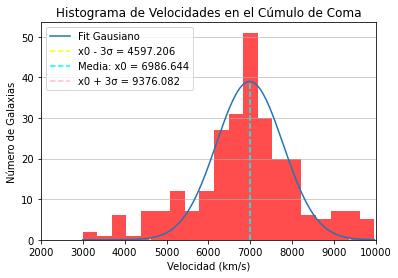

In [126]:
plt.ticklabel_format(style='plain')
plt.hist(velocities,bins=20, color='red', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title('Histograma de Velocidades en el Cúmulo de Coma')
plt.xlabel('Velocidad (km/s)')
plt.ylabel('Número de Galaxias')
plt.plot(x, y, '-', label='Fit Gausiano')
plt.xlim(2000,10000)
plt.vlines(line_values[0],0,gauss(line_values[0],*parameters), linestyle='--', color='yellow',label='x0 - 3σ = 4597.206')
plt.vlines(line_values[1],0,gauss(line_values[1],*parameters), linestyle='--', color='cyan',label='Media: x0 = 6986.644')
plt.vlines(line_values[2],0,gauss(line_values[2],*parameters), linestyle='--', color='pink',label='x0 + 3σ = 9376.082')
plt.legend()
plt.savefig('Gaussian Fit Histogram.png')

Del histograma presentado, se ouede observar que cerca del 92% de las galaxias se encuentran dentro del rango de 3σ de la media:

In [127]:
histograma_intervalo(min_limit,max_limit)*100/len(velocities)

91.66666666666667

Luego, de la tabla general obtenida, se procedió a realizar el filtro para quedarnos con una tabla que contenga solo con las galaxias que se encuentren dentro del rango de 3σ de la media, que las tomaremos como las galaxias que pertenecen al Cúmulo de Coma: 

In [128]:
result_coma = result_total.query('Velocity >= @min_limit and Velocity <= @max_limit')
print(result_coma)

              RA       DEC  Velocity  Redshift  umag  e_umag  gmag  e_gmag  \
1      194.89878  27.95927    7167.0  0.023907   NaN     NaN   NaN     NaN   
13     194.95246  27.98274    5358.0  0.017872   NaN     NaN   NaN     NaN   
18     194.97955  28.12836    7564.0  0.025231   NaN     NaN   NaN     NaN   
21     194.85553  27.96793    7706.0  0.025704   NaN     NaN   NaN     NaN   
31     195.00429  28.08186    7765.0  0.025900   NaN     NaN   NaN     NaN   
...          ...       ...       ...       ...   ...     ...   ...     ...   
49112  195.12872  27.97443    6315.0  0.021065   NaN     NaN   NaN     NaN   
49308  194.93904  27.85700    6410.0  0.021381   NaN     NaN   NaN     NaN   
49432  194.88512  27.86317    6719.0  0.022412   NaN     NaN   NaN     NaN   
49446  194.93775  27.84844    8520.0  0.028420   NaN     NaN   NaN     NaN   
49642  194.92720  28.13554    9174.0  0.030600   NaN     NaN   NaN     NaN   

       rmag  e_rmag  imag  e_imag  zmag  e_zmag  
1       NaN  

Por otro lado, se procedió a extraer las magnitudes en los diferentes filtros y los indices de color (U-G y R-I) para las galaxias del cúmulo:

En un caso ideal, para realizar el Diagrama de Color-Magnitud del Cúmulo de Coma se debería trabajar solo con las galaxias que tienen velocidades entre -3σ y 3σ de la media de velocidad (result_coma), pero en este caso, se observó que justo de esas galaxias no se poseía casi ningún dato de magnitud en los diferentes filtros, por lo que se procedió a trabajar con el set de datos completos (antes de realizar el filtro: result_total) o lo que es lo mismo, no con el 92% de las galaxias del histograma, sino con el 100% de estas.

In [129]:
umag = result_total['umag']
gmag = result_total['gmag']
rmag = result_total['rmag']
imag = result_total['imag']
zmag = result_total['zmag']

ri_color = rmag - imag
ug_color = umag - gmag

Diagrama Color-Magnitud del Cúmulo de Coma en los filtros I y R:

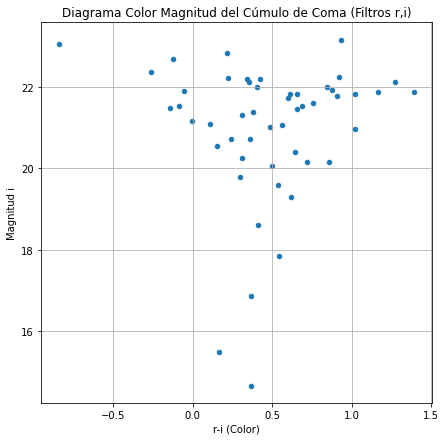

In [130]:
fig = plt.figure(figsize=(7,7))
plt.grid(True)
plt.title('Diagrama Color Magnitud del Cúmulo de Coma (Filtros r,i)')
plt.scatter(ri_color, imag,s=20)
plt.xlabel('r-i (Color)')
plt.ylabel('Magnitud i')
fig.savefig('plotRI.png')

Diagrama Color-Magnitud del Cúmulo de Coma en los filtros U y G:

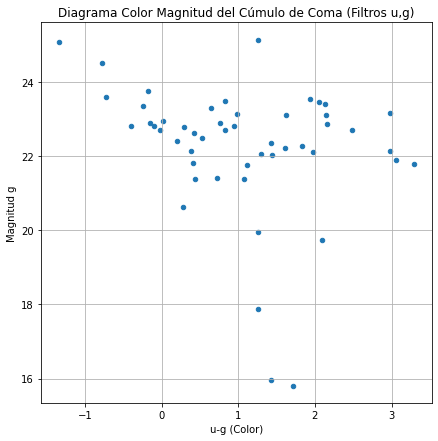

In [131]:
fig = plt.figure(figsize=(7,7))
plt.grid(True)
plt.title('Diagrama Color Magnitud del Cúmulo de Coma (Filtros u,g)')
plt.scatter(ug_color, gmag,s=20)
plt.xlabel('u-g (Color)')
plt.ylabel('Magnitud g')
fig.savefig('plotUG.png')

Extracción de los datos de Redshift:

In [132]:
z = result_coma['Redshift']
c = 299792 #Definición de la velocidad de la luz en km/s

Se añadió una columna al dataframe con los valores de c.z (km/s):

In [133]:
cz = [n * c for n in z]
result_coma = result_coma.assign(cz= cz)

In [134]:
result_coma

,RA,DEC,Velocity,Redshift,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,cz
1,194.89878,27.95927,7167.0,0.023907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7167.127344
13,194.95246,27.98274,5358.0,0.017872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5357.882624
18,194.97955,28.12836,7564.0,0.025231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7564.051952
21,194.85553,27.96793,7706.0,0.025704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7705.853568
31,195.00429,28.08186,7765.0,0.025900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7764.612800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49112,195.12872,27.97443,6315.0,0.021065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6315.118480
49308,194.93904,27.85700,6410.0,0.021381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6409.852752
49432,194.88512,27.86317,6719.0,0.022412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6718.938304
49446,194.93775,27.84844,8520.0,0.028420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8520.088640


Se definió la posición en coordenadas ecuatoriales J200 (RA y DEC en radianes) del centro del Cúmulo de Coma:

In [135]:
coma_ra = 194.9531 * 2*np.pi/360
coma_dec = 27.9807 * 2*np.pi/360    
coma_position = [coma_ra, coma_dec]

Cálculo de las ascenciones rectas y declinaciones, de las galaxias del cúmulo de Coma, en radianes:

In [136]:
ra = result_coma['RA'] * 2*np.pi/360
dec = result_coma['DEC'] * 2*np.pi/360

Se definió una nueva columna con los valores de las distancias de cada galaxia al centro del cúmulo en arcmin:

Para calcular el valor de la distancia d en radianes se utilizó la siguiente fórmula:

$$
|d_{rad}(ra,dec)|=2\arcsin{\sqrt{\sin^2{(\frac{dec_{coma}-dec_{galaxy}}{2}})+\cos{(ra_{coma})}·\cos{(ra_{galaxy})}·\sin^2{(\frac{ra_{coma}-ra_{galaxy}}{2}})}}
$$

Para convertir la distancia de radianes a arcmin, se paso primero a grados sexagesimales y luego a arco minutos:

$$
|d_{arcmin}(ra,dec)|=\frac{|d_{rad}(ra,dec)|·360°·60arcmin}{2\pi}
$$

Por último, para conservar el signo de la distancia (de que lado desde el centro de la galaxia se encuentra), se multiplicó por el signo de la diferencia entre las ascenciones rectas:

$$
d_{arcmin}(ra,dec)=\frac{|d_{arcmin}(ra,dec)|·(ra_{coma}-ra_{galaxy})}{|ra_{coma}-ra_{galaxy}|}
$$

In [137]:
Distancia = (coma_ra-ra)*(2*np.arcsin((np.sin((coma_dec-dec)/2)**2+np.cos(coma_dec)*np.cos(dec)*np.sin((coma_ra-ra)/2)**2)**0.5))*360*60/(2*np.pi)/np.abs(coma_ra-ra)

result_coma = result_coma.assign(Distancia= Distancia)
result_coma

,RA,DEC,Velocity,Redshift,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,cz,Distancia
1,194.89878,27.95927,7167.0,0.023907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7167.127344,3.152628
13,194.95246,27.98274,5358.0,0.017872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5357.882624,0.127011
18,194.97955,28.12836,7564.0,0.025231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7564.051952,-8.969615
21,194.85553,27.96793,7706.0,0.025704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7705.853568,5.226649
31,195.00429,28.08186,7765.0,0.025900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7764.612800,-6.647563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49112,195.12872,27.97443,6315.0,0.021065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6315.118480,-9.313332
49308,194.93904,27.85700,6410.0,0.021381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6409.852752,7.459338
49432,194.88512,27.86317,6719.0,0.022412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6718.938304,7.919374
49446,194.93775,27.84844,8520.0,0.028420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8520.088640,7.977223


Scatter Plot de densidad de distribución de galaxias en el cúmulo de Coma:

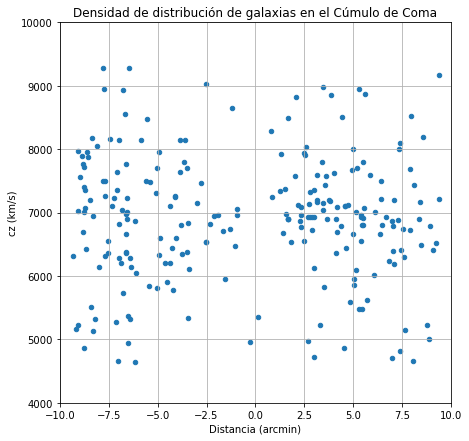

In [138]:
fig = plt.figure(figsize=(7,7))
plt.grid(True)
plt.title('Densidad de distribución de galaxias en el Cúmulo de Coma')
plt.scatter(result_coma['Distancia'],result_coma['cz'],s=20)
plt.xlabel('Distancia (arcmin)')
plt.ylabel('cz (km/s)')
plt.ylim(4000,10000)
plt.xlim(-10,10)
fig.savefig('Scatter Galaxy Density Distribution.png')

Gráfico de densidad de distribución de galaxias en el cúmulo de Coma:

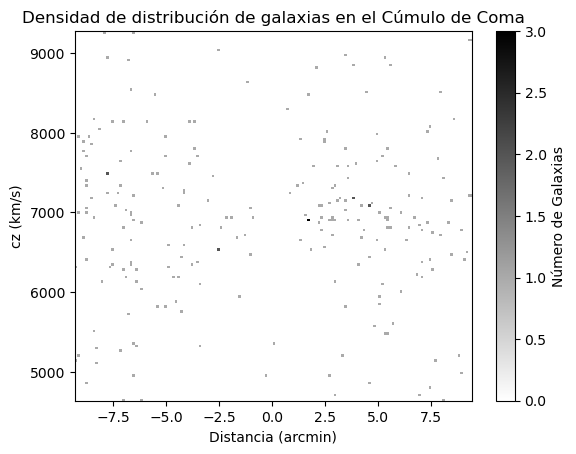

In [139]:
with plt.style.context('default'):
    plt.hist2d(result_coma['Distancia'], result_coma['cz'], bins=150, 
               cmap='gray_r', norm = mpl.colors.Normalize())

    plt.xlabel('Distancia (arcmin)')
    plt.title('Densidad de distribución de galaxias en el Cúmulo de Coma')
    plt.ylabel('cz (km/s)')
    plt.colorbar(label='Número de Galaxias')
    plt.savefig('Galaxy Density Distribution.png')

Se calculó los valores mínimo y máximo de cz:

In [140]:
minimo_cz = min(cz)
maximo_cz = max(cz)
print([minimo_cz,maximo_cz])

[4637.78224, 9275.864272]


Se le aplicó la función de histograma a la columna cz:

In [141]:
histogram_cz = histograma(cz)

Se le realizó el curve_fit gausiano al histograma de cz para hallar los parámetros óptimos:

In [142]:
parameters_cz, covariance_cz = curve_fit(gauss, histogram_cz[0], histogram_cz[1],p0=[37,7000,650])

In [143]:
sigma_cz = parameters_cz[2]
media_cz = parameters_cz[1]
print([media_cz,sigma_cz])

[6986.645543245626, 796.4266667248024]


Se calculó los valores de cz límites que estan a 3σ de la media:

In [144]:
line_values_cz = [media_cz-3*sigma_cz,media_cz,media_cz+3*sigma_cz]
print([line_values_cz[0],line_values_cz[2]])

[4597.365543071219, 9375.925543420033]


Se realizó el histograma de la distribución de velocidades con su respectivo ajuste gausiano:

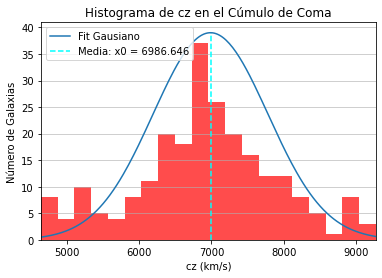

In [145]:
xc = np.linspace(minimo_cz,maximo_cz,200)
yc = gauss(xc,*parameters_cz)
plt.ticklabel_format(style='plain')
plt.hist(cz,bins=20, color='red', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title('Histograma de cz en el Cúmulo de Coma')
plt.xlabel('cz (km/s)')
plt.ylabel('Número de Galaxias')
plt.plot(xc, yc, '-', label='Fit Gausiano')
plt.xlim(minimo_cz,maximo_cz)
plt.vlines(line_values_cz[1],0,gauss(line_values_cz[1],*parameters_cz), linestyle='--', color='cyan',label='Media: x0 = 6986.646')
plt.legend()
plt.savefig('Histogram of cz.png')

Del gráfico, se puede observar que el 100% de la data está dentro de los límites de 3σ; por lo que, de acuerdo a este criterio, para realizar los siguientes gráficos se procederá a utilizar el dataframe completo con todas las galaxias (result_total), además que no se utilizó el dataframe filtrado con el criterio del 3σ del histograma de velocidades (result_coma) porque no se contaban con los suficientes datos de magnitudes en niguno de los filtros.

In [146]:
histograma_intervalo(media_cz-3*sigma_cz,media_cz+3*sigma_cz)*100/len(cz)

102.54237288135593

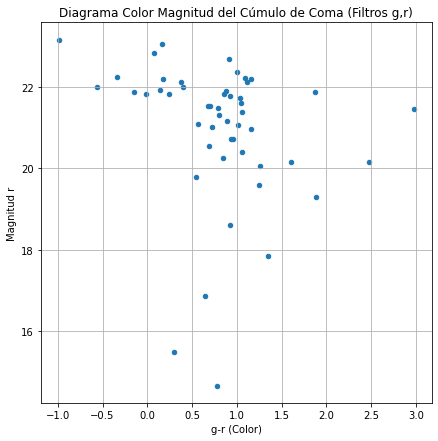

In [147]:
gr_color = gmag - rmag
ur_color = umag - rmag
fig = plt.figure(figsize=(7,7))
plt.grid(True)
plt.title('Diagrama Color Magnitud del Cúmulo de Coma (Filtros g,r)')
plt.scatter(gr_color, imag,s=20)
plt.xlabel('g-r (Color)')
plt.ylabel('Magnitud r')
fig.savefig('plotgr.png')

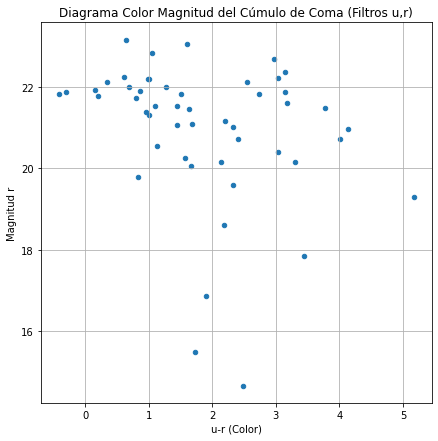

In [148]:
fig = plt.figure(figsize=(7,7))
plt.grid(True)
plt.title('Diagrama Color Magnitud del Cúmulo de Coma (Filtros u,r)')
plt.scatter(ur_color, imag,s=20)
plt.xlabel('u-r (Color)')
plt.ylabel('Magnitud r')
fig.savefig('plotur.png')

In [ ]:
histogram1_zspx = histogram_zsp[0][np.logical_and(histogram_zsp[0] >= min(histogram_zsp[0]), histogram_zsp[0] <= 0.133)]
histogram1_zspy = histogram1_zsp[1][0:len(histogram1_zspx)]

histogram2_zspx = histogram_zsp[0][np.logical_and(histogram_zsp[0] > 0.133, histogram_zsp[0] <= max(histogram_zsp[0]))]
histogram_zsp[1][17:]=0
histogram2_zspy = histogram2_zsp[1][0:len(histogram2_zspx)]